# Dealing with data imbalance

When classes are imbalanced a problem that appears is that the classification for the labels that are least represented tends to be poor. In order to explore this problem, we will be using data from the UCI Machine Learning Repository. The [Balance Scale Dataset](http://archive.ics.uci.edu/ml/datasets/balance+scale) is a synthetic dataset that was created to explore this problem.

The dataset contains 3 labels (B, L, R) and it has 4 variables as features. The data was generated in the following way:

* Generate var1, var2, var3, var4

* If var3 * var4 > var1 * var2 generate R

* If var3 * var4 < var1 * var2 generate L

* If var3 * var4 = var1 * var2 generate B

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

%matplotlib inline


In [2]:
df = pd.read_csv('balancescale.csv', 
                 names=['balance', 'var1', 'var2', 'var3', 'var4'])

df.head()

,balance,var1,var2,var3,var4
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5


Let's see if we have unbalanced classes

In [3]:
df['balance'].value_counts()

L    288
R    288
B     49
Name: balance, dtype: int64

It seems that B has significantly less observations than the rest of the data. I will use a classification model that we have not before. Logistic regression. 

I will use it because it does not require any hyperparameters. 

In [4]:
#Binarizing to make things simpler:


df['balance'] = [1 if b=='B' else 0 for b in df.balance]

In [5]:
y=df['balance']

X=df[['var1', 'var2', 'var3', 'var4']]

In [6]:
#Let's get predictions

predLR=LogisticRegression().fit(X,y).predict(X)

df['predLR']=predLR

df.head()

,balance,var1,var2,var3,var4,predLR
0,1,1,1,1,1,0
1,0,1,1,1,2,0
2,0,1,1,1,3,0
3,0,1,1,1,4,0
4,0,1,1,1,5,0


In [7]:
print(classification_report(y_pred=df['predLR'], y_true=df['balance']))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       576
           1       0.00      0.00      0.00        49

    accuracy                           0.92       625
   macro avg       0.46      0.50      0.48       625
weighted avg       0.85      0.92      0.88       625



/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/pablocrespo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Wait... what

In [8]:
df['predLR'].unique()

array([0])

All the predicted values are 0!

## Two ways to deal with this:

We would very much like to balance our classes  

1. Upsample the data with few observations
2. Downsample the data with lots of observations

Scikit-learn thankfully has a way to do this.


In [9]:
from sklearn.utils import resample


In [10]:
# Separate majority and minority classes

df_majority = df[df['balance']==0]

df_minority = df[df['balance']==1]

In [11]:
df_majority.shape

(576, 6)

In [12]:
df_minority.shape

(49, 6)

## Upsampling minority class

We will generate repetitions of the rows of the minority class at random

In [13]:
df_minority_up = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=576,   
                                 random_state=42) 
 

In [14]:
df_minority_up.shape

(576, 6)

In [15]:
#let's concatenate the datasets to make our new one

df_up=pd.concat([df_majority, df_minority_up])

In [16]:
df_up.tail()

,balance,var1,var2,var3,var4,predLR
598,1,5,4,5,4,0
438,1,4,3,3,4,0
208,1,2,4,2,4,0
624,1,5,5,5,5,0
494,1,4,5,4,5,0


In [17]:
df_up.drop(columns='predLR', inplace=True)

In [18]:
features=['var1', 'var2', 'var3', 'var4']

predLR2=LogisticRegression().fit(X=df_up[features],
                                y=df_up['balance']).predict(df_up[features])

In [19]:
df_up['predLR']=predLR2

In [20]:
print(classification_report(y_pred=df_up['predLR'],
                            y_true=df_up['balance']))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       576
           1       0.53      0.53      0.53       576

    accuracy                           0.53      1152
   macro avg       0.53      0.53      0.53      1152
weighted avg       0.53      0.53      0.53      1152



We are no longer predicting just one class! However, we got a pretty bad hit on the 0 class. However, that is still an overall better result than no classification at all. What about AUC scores?

In [21]:
roc_auc_score(y_true=df.balance, 
              y_score=LogisticRegression().fit(X,y).predict_proba(X)[:, 1])

0.530452806122449

In [22]:
roc_auc_score(y_true=df_up.balance, 
              y_score=LogisticRegression().fit(df_up[features],df_up.balance).predict_proba(df_up[features])[:, 1])

0.54297176408179

This improved things a bit

## Downsampling majority data

In [23]:
df_majority_down = resample(df_majority, 
                                 replace=True,     
                                 n_samples=49,   
                                 random_state=42) 
 

In [24]:
df_down=pd.concat([df_majority_down, df_minority])

In [25]:
df_down.head()

,balance,var1,var2,var3,var4,predLR
111,0,1,5,3,2,0
473,0,4,4,5,4,0
295,0,3,2,5,1,0
115,0,1,5,4,1,0
76,0,1,4,1,2,0


In [26]:
df_down.drop(columns='predLR', inplace=True)

In [27]:
predLR3=LogisticRegression().fit(X=df_down[features],
                                y=df_down['balance']).predict(df_down[features])

In [28]:
df_down['predLR']=predLR3

In [29]:
df_down.head()

,balance,var1,var2,var3,var4,predLR
111,0,1,5,3,2,0
473,0,4,4,5,4,0
295,0,3,2,5,1,0
115,0,1,5,4,1,0
76,0,1,4,1,2,1


Let's look at the classification report

In [30]:
print(classification_report(y_pred=df_down['predLR'],
                            y_true=df_down['balance']))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54        49
           1       0.54      0.55      0.55        49

    accuracy                           0.54        98
   macro avg       0.54      0.54      0.54        98
weighted avg       0.54      0.54      0.54        98



What about the ROC AUC score?

In [31]:
roc_auc_score(y_true=df_down.balance, 
              y_score=LogisticRegression().fit(df_down[features],df_down.balance).predict_proba(df_down[features])[:, 1])

0.5472719700124948

This is the best one so far!

Imbalance is a significantly difficult problem to solve. The techniques I have shown you are popular because they are better than no alternatives. But generally, we might want to use them in combination of models that use multiple submodels. The only case we have studied of such are Random forests.

# Unsupervised learning

So far we have dealt with predictions based on some dependent ($y$) and indepent variables ($X$). The dependent variables being generally our target for prediction. But what happens if we have data for which labels are not available?

We might still want to group them. The set of algorithms and models that do such are called unsupervised algorithms. We will see one of those called "K-means clustering"

In [32]:
#Let's load our iris dataset

iris = datasets.load_iris()


We will turn this into a dataframe to handle it more easily

In [33]:
iris_df = pd.DataFrame(iris.data,columns=iris.feature_names)
iris_df['label']=pd.Series(iris.target)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In this case the labels have 4 possible dimensions. How easy would it be for us to visualize how the labels are grouped if we were to plot the data.

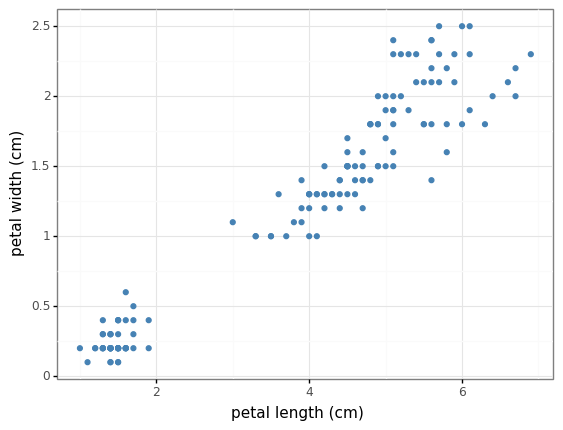

<ggplot: (8785527102531)>

In [34]:
(ggplot(iris_df, aes(x='petal length (cm)', y='petal width (cm)'))+
      geom_point(color='steelblue')+
      theme_bw())

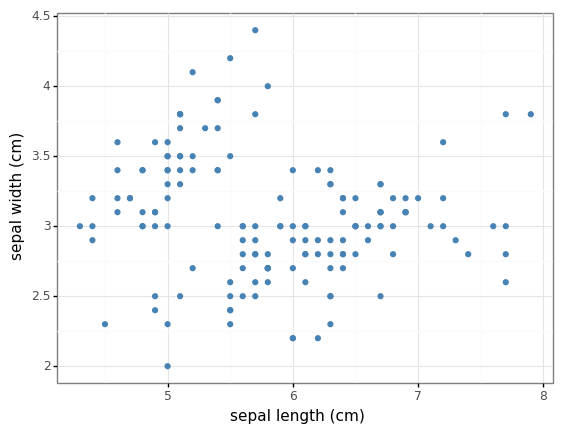

<ggplot: (8785447928757)>

In [35]:
(ggplot(iris_df, aes(x='sepal length (cm)', y='sepal width (cm)'))+
      geom_point(color='steelblue')+
      theme_bw())

It's not particularly easy to see it, but we can see that there are at least 2 different groups. We can use the distances of the features to build groups. 

## K means clustering

This algorightm simply picks K groups of data or clusters based on how distant they are to a "centroid" that defines the group. The algorithm is composed of the following steps:


* Select a specific number (K) of groups 

* Generate K observations at random within the scope of our data (centroids) 

* Compute all the distances from all the observations to the centroids

* Assign to the same group the points to their closest centroid

* Average out the observations for each group to generate new centroids

* Repeat the last 3 steps until the observations stop changing their group assignment significantly


In [36]:
from sklearn.cluster import KMeans

#Let's try with three clusters

kmeans=KMeans(n_clusters=3)


In [37]:
features=['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

features

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [38]:
#Let's get the predictions

iris_df['kpreds']=kmeans.fit(iris_df[features]).predict(iris_df[features])

In [39]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,kpreds
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0


Note that we are not checking to see if the true labels are matched by the predictions because we generally don't have the true labels when we do this kind of work! We have them here for instructional purposes.

Let's look at the original data and its labels

(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='petal width (cm)', color='factor(label)'))+
geom_point()+
theme_bw())

Let's look at the predicted data now

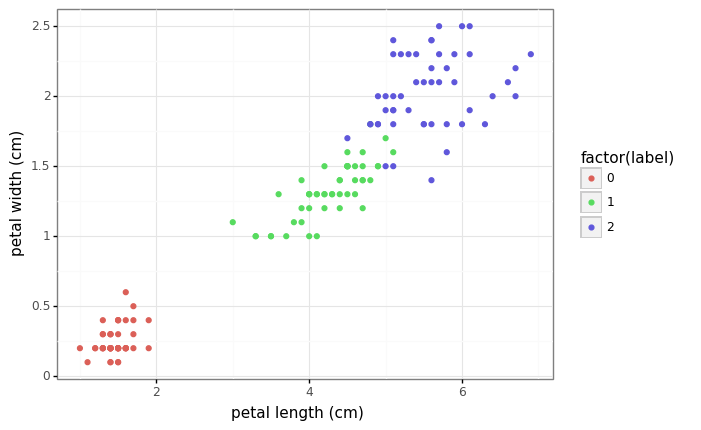

<ggplot: (8785527160920)>

In [40]:
(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='petal width (cm)', color='factor(label)'))+
geom_point()+
theme_bw())

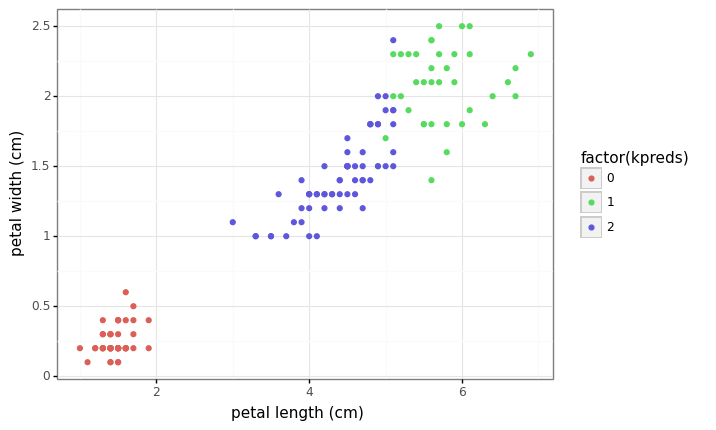

<ggplot: (8785457098045)>

In [41]:
(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='petal width (cm)', color='factor(kpreds)'))+
geom_point()+
theme_bw())

Nice! While we knew the data labels followed species, or K means algorithm did not and it seems to still have caught the  general points that are latently separated. Let's add the centroids to the plot and let's see it in different dimensions to see if the splits make sense.

In [42]:
centroids_df=pd.DataFrame(kmeans.cluster_centers_,
                          columns=iris.feature_names)

Showing the first

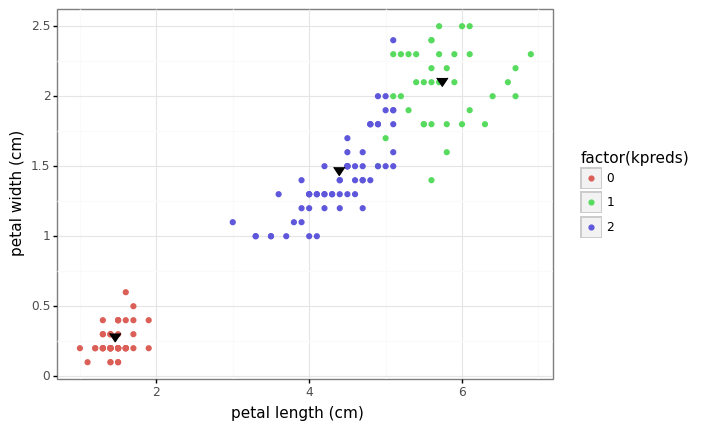

<ggplot: (8785527201877)>

In [43]:
(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='petal width (cm)', color='factor(kpreds)'))+
geom_point()+
 geom_point(data=centroids_df, mapping=aes(x='petal length (cm)',
                                          y='petal width (cm)'),
           color='black', shape=7, size=4)+
theme_bw())

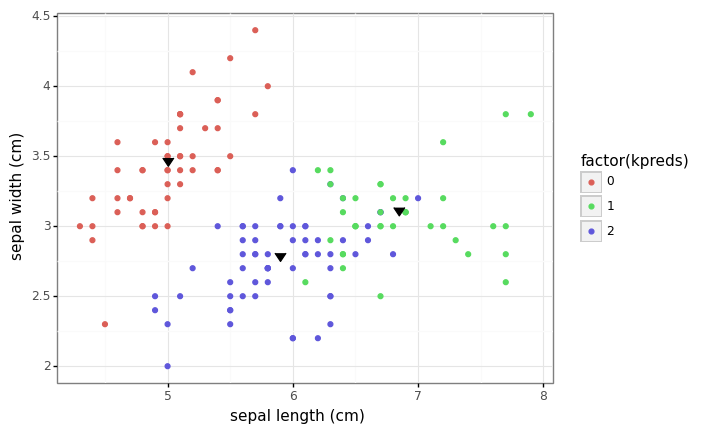

<ggplot: (8785456992835)>

In [44]:
(ggplot(data=iris_df, mapping=aes(x='sepal length (cm)',
                                 y='sepal width (cm)', color='factor(kpreds)'))+
geom_point()+
 geom_point(data=centroids_df, mapping=aes(x='sepal length (cm)',
                                          y='sepal width (cm)'),
           color='black', shape=7, size=4)+
theme_bw())

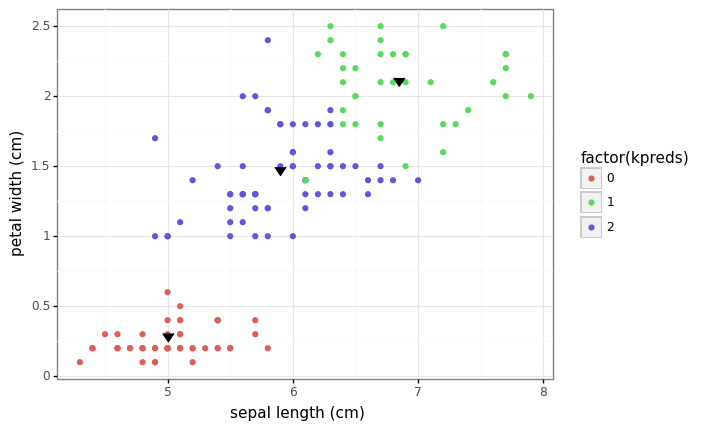

<ggplot: (8785527254203)>

In [45]:
(ggplot(data=iris_df, mapping=aes(x='sepal length (cm)',
                                 y='petal width (cm)', color='factor(kpreds)'))+
geom_point()+
 geom_point(data=centroids_df, mapping=aes(x='sepal length (cm)',
                                          y='petal width (cm)'),
           color='black', shape=7, size=4)+
theme_bw())

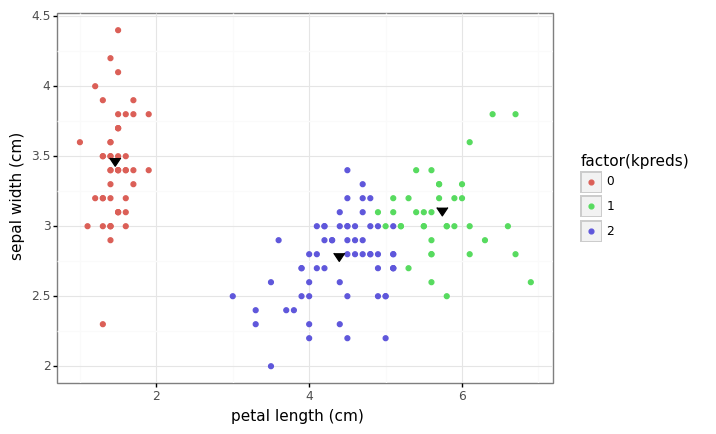

<ggplot: (8785527950270)>

In [46]:
(ggplot(data=iris_df, mapping=aes(x='petal length (cm)',
                                 y='sepal width (cm)', color='factor(kpreds)'))+
geom_point()+
 geom_point(data=centroids_df, mapping=aes(x='petal length (cm)',
                                          y='sepal width (cm)'),
           color='black', shape=7, size=4)+
theme_bw())

This looks great, we can see why it works. But one problem is that we picked 3 groups knowing a priori there was 3 species, what if we said 5?

In [47]:
kmeans5=KMeans(n_clusters=5)


In [48]:
iris_df['kpreds5']=kmeans5.fit(iris_df[features]).predict(iris_df[features])

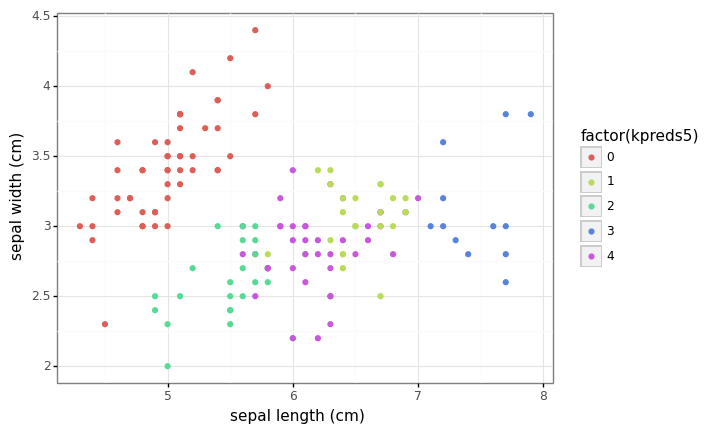

<ggplot: (8785527203777)>

In [50]:
(ggplot(data=iris_df, mapping=aes(x='sepal length (cm)',
                                 y='sepal width (cm)', color='factor(kpreds5)'))+
geom_point()+
theme_bw())